<a href="https://colab.research.google.com/github/harishk30/GNNcom/blob/main/COM_GNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install torch_geometric

In [ ]:
import torch
from torch_geometric.data import Data

## Creating/Loading Data

In [ ]:
import random
import numpy as np
import time
#Look at seed
rng = np.random.default_rng()
def create_points(cube_length):
  points = []
  mass = []
  for i in range (0, 100):
    np.random.seed(seed=int(random.randint(0, 2024)))
    random_dist = random.randrange(1, 2)
    x = rng.random() * cube_length
    y = rng.random() * cube_length
    z = rng.random() * cube_length
    m = rng.random() * 100
    points.append([x, y, z])
    mass.append(m)
  com = []
  numerator_x = 0
  numerator_y = 0
  numerator_z = 0
  den = 0
  for i in range(len(points)):
    numerator_x += mass[i] * points[i][0]
    numerator_y += mass[i] * points[i][1]
    numerator_z += mass[i] * points[i][2]
    den += mass[i]
  com = [numerator_x/den, numerator_y/den, numerator_z/den]
  return [points, com, mass]

In [ ]:
points = create_points(100)

In [ ]:
import math
def distance(point1, point2):
  return math.sqrt((point2[0] - point1[0])**2 + (point2[1] - point1[1])**2 + (point2[2] - point1[2])**2)

In [ ]:
def create_edges(points, dist):
  edges = []
  edge_value = []
  for i in range(0, len(points[0])):
    for j in range(0, len(points[0])):
      if(j != i):
        two_dist = distance(points[0][j], points[0][i])
        if(two_dist <= dist):
          edges.append([i, j])
          edge_value.append(two_dist)
  return [edges, edge_value]

In [ ]:
from scipy.spatial import KDTree

def create_edges_knn(points, k):
    edges = []
    edge_value = []

    point_tree = KDTree(points[0])

    for i in range(len(points[0])):
        # Query the k nearest neighbors for each point
        _, neighbors = point_tree.query(points[0][i], k=k+1)

        for j in neighbors[1:]:
            # Add an edge between the point and its neighbor
            edges.append([i, j])

            # Compute the distance between the points as the edge value
            edge_value.append(distance(points[0][i], points[0][j]))

    return [edges, edge_value]

In [ ]:
edges = create_edges_knn(points, k=6)
edge = edges[0]
edge_value = edges[1]

In [ ]:
point_values = points[0]
center_of_mass = points[1]

In [ ]:
for i in range(len(points[0])):
  point_values[i].append(points[2][i])

In [ ]:
def create_graph(cube_len, i):
  points = create_points(cube_len)
  edges = create_edges_knn(points, k = 3)
  edge = edges[0]
  edge_value = edges[1]
  point_values = points[0]
  center_of_mass = points[1]
  for i in range(len(points[0])):
    point_values[i].append(points[2][i])
  edge_index = torch.tensor(edge, dtype=torch.long)
  point_values = torch.tensor(point_values, dtype=torch.float)
  edge_value = torch.tensor(edge_value, dtype=torch.float)
  center_of_mass = torch.tensor(center_of_mass, dtype=torch.float)
  return [point_values, edge_index.t().contiguous(), edge_value, center_of_mass]

In [ ]:
from torch_geometric.transforms import RandomNodeSplit
import torch_geometric.transforms as T
import torch.nn.functional as F
def turn_data(graph):
  graph_data = Data(x = graph[0], edge_index = graph[1], edge_attr = graph[2], y = graph[3])
  return graph_data

In [ ]:
def apply_min_max_normalization(data_list):

    # Concatenate all data points to find the global min and max
    all_data_points = torch.cat([data.x for data in data_list], dim=0)
    min_values, _ = torch.min(all_data_points, dim=0)
    max_values, _ = torch.max(all_data_points, dim=0)

    # Apply Min-Max normalization
    for data in data_list:
        data.x = (data.x - min_values) / (max_values - min_values)

    return data_list

In [ ]:
import torch

def standardize_data(data_list):
    # Assuming data_list is a list of Data objects from PyTorch Geometric

    # Concatenate all data points to find the global mean and standard deviation
    all_data_points = torch.cat([data.x for data in data_list], dim=0)
    mean = torch.mean(all_data_points, dim=0)
    std = torch.std(all_data_points, dim=0)

    # Apply standardization
    for data in data_list:
        data.x = (data.x - mean) / (std + 1e-9)  # The 1e-9 avoids division by zero

    return data_list


In [ ]:
def create_training(x, i, cube_len):
  data_list=[]
  for j in range(x):
    data_list.append(turn_data(create_graph(cube_len, i)))
  return data_list

In [ ]:
from torch_geometric.loader import DataLoader
data_list = create_training(10000, 3, 100)
all_data_points = torch.cat([data.x for data in data_list], dim=0)
mean = torch.mean(all_data_points, dim=0)
std = torch.std(all_data_points, dim=0)
all_data_points = torch.cat([data.x for data in data_list], dim=0)
#min_values, _ = torch.min(all_data_points, dim=0)
#max_values, _ = torch.max(all_data_points, dim=0)
data_list = standardize_data(data_list)

In [ ]:
mean

tensor([49.9497, 50.0032, 49.9744, 49.9431])

In [ ]:
graph = data_list[0]

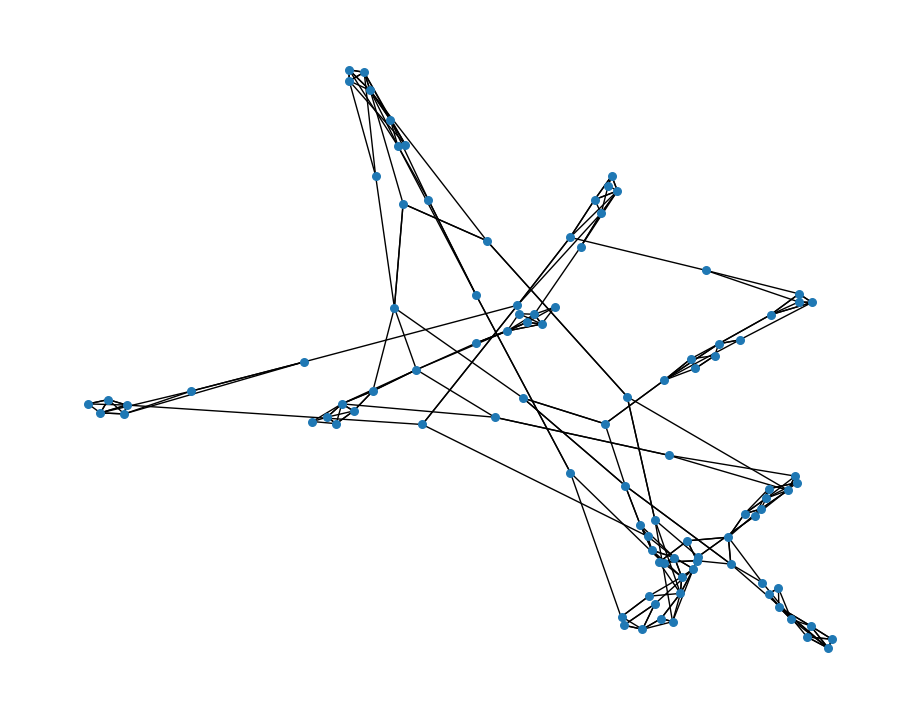

In [ ]:
#EXTERNAL CODE
import random
from torch_geometric.utils import to_networkx
import networkx as nx
import matplotlib.pyplot as plt

def convert_to_networkx(graph, n_sample=None):

    g = to_networkx(graph, node_attrs=["x"])
    y = graph.y.numpy()

    if n_sample is not None:
        sampled_nodes = random.sample(g.nodes, n_sample)
        g = g.subgraph(sampled_nodes)
        y = y[sampled_nodes]

    return g, y


def plot_graph(g, y):

    plt.figure(figsize=(9, 7))
    nx.draw_spring(g, node_size=30, arrows=False)
    plt.show()


g, y = convert_to_networkx(graph)
plot_graph(g, y)

In [ ]:
train_dataset = data_list[:7000]
test_dataset = data_list[7000:]

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

## Graph Neural Network

In [ ]:
def normalize(data, mean, std):
   data.x = (data.x - mean) / (std + 1e-9)
   return data


In [ ]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GATConv
from torch_geometric.nn import global_mean_pool
# Pytorch Geometric tutorial & https://medium.com/stanford-cs224w/incorporating-edge-features-into-graph-neural-networks-for-country-gdp-predictions-1d4dea68337d

class GAT(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GAT, self).__init__()
        torch.manual_seed(torch.random.seed())
        self.convs = [GATConv(data_list[0].num_node_features, hidden_channels, edge_dim = data_list[0].num_edge_features),
                      GATConv(hidden_channels, hidden_channels * 2, edge_dim=data_list[0].num_edge_features),
                      GATConv(hidden_channels * 2, hidden_channels, edge_dim=data_list[0].num_edge_features),
                      GATConv(hidden_channels, hidden_channels, edge_dim = data_list[0].num_edge_features)]
        self.lin = Linear(hidden_channels, 3)

    def forward(self, data):
        x = data.x
        edge_index = data.edge_index
        batch = data.batch
        edge_attr = data.edge_attr

        # 1. Convolutions
        for conv in self.convs[:-1]:
          x = conv(x, edge_index, edge_attr = edge_attr)
          x = F.relu(x)
          x = F.dropout(x, p=0.6, training=self.training)
        x = self.convs[-1](x, edge_index, edge_attr=edge_attr)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Classification
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.lin(x)
        return x

model = GAT(hidden_channels=64)
print(model)

GAT(
  (lin): Linear(in_features=64, out_features=3, bias=True)
)


In [ ]:
from torch.nn import Linear, ModuleList
import torch.nn.functional as F
from torch_geometric.nn import GATConv, global_mean_pool
import torch

class ComplexGAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers=4, heads=4, dropout_rate=0.5):
        super(ComplexGAT, self).__init__()
        torch.manual_seed(42)  # Fixed seed for reproducibility

        self.heads = heads
        self.hidden_channels = hidden_channels
        self.out_channels = out_channels

        # Initial convolution layer
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads, concat=True)

        # Hidden layers
        self.convs = ModuleList()
        for _ in range(1, num_layers - 1):
            self.convs.append(GATConv(hidden_channels * heads, hidden_channels, heads=heads, concat=True))

        # Concat = False so seperately considering all points
        self.conv_last = GATConv(hidden_channels * heads, hidden_channels, heads=1, concat=False)

        # New branch for every dimension
        self.branches = ModuleList([Linear(hidden_channels, 1) for _ in range(out_channels)])

        self.dropout_rate = dropout_rate

    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch

        # Initial convolution
        x = F.relu(self.conv1(x, edge_index, edge_attr=edge_attr))
        x = F.dropout(x, p=self.dropout_rate, training=self.training)

        # Hidden layers
        for conv in self.convs:
            x = F.relu(conv(x, edge_index, edge_attr=edge_attr))
            x = F.dropout(x, p=self.dropout_rate, training=self.training)

        # Final convolution
        x = self.conv_last(x, edge_index, edge_attr=edge_attr)

        # Readout layer
        x = global_mean_pool(x, batch)

        # Apply separate branches for X, Y, and Z
        outs = [branch(x) for branch in self.branches]

        # Concatenate the outputs from each branch to form the final output
        out = torch.cat(outs, dim=1)

        return out

num_features = data_list[0].num_node_features
model = ComplexGAT(in_channels=num_features, hidden_channels=64, out_channels=3, num_layers=3, heads=4, dropout_rate=0.5)
print(model)

ComplexGAT(
  (conv1): GATConv(4, 64, heads=4)
  (convs): ModuleList(
    (0): GATConv(256, 64, heads=4)
  )
  (conv_last): GATConv(256, 64, heads=1)
  (branches): ModuleList(
    (0-2): 3 x Linear(in_features=64, out_features=1, bias=True)
  )
)


In [ ]:
import torch.nn as nn
class RMSLELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()

    def forward(self, pred, actual):
        return torch.sqrt(self.mse(torch.log(pred + 1), torch.log(actual + 1)))

In [ ]:
from IPython.display import Javascript
import torch.nn as nn
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = ComplexGAT(in_channels=num_features, hidden_channels=64, out_channels=3, num_layers=3, heads=4, dropout_rate=0.5)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)
criterion = RMSLELoss()

def train():
    model.train()
    for data in train_loader:  # Iterate in batches over the training dataset.
         out = model(data)  # Perform a single forward pass.
         out = torch.flatten(out)
         loss = criterion(out, data.y)  # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.
    scheduler.step()

def test(loader):
     model.eval()
     tot = 0
     num = 0
     for data in loader:
      out = model(data)
      pred = torch.flatten(out)
      tot += criterion(pred, data.y)
      num += 1
     return tot/num  # Derive ratio of correct predictions.


for epoch in range(1, 15):
    train()
    train_loss = test(train_loader)
    test_loss = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

<IPython.core.display.Javascript object>

Epoch: 001, Train Loss: 0.0611, Test Loss: 0.0610
Epoch: 002, Train Loss: 0.0775, Test Loss: 0.0771
Epoch: 003, Train Loss: 0.0798, Test Loss: 0.0794
Epoch: 004, Train Loss: 0.0458, Test Loss: 0.0456
Epoch: 005, Train Loss: 0.0527, Test Loss: 0.0523
Epoch: 006, Train Loss: 0.0417, Test Loss: 0.0414
Epoch: 007, Train Loss: 0.0723, Test Loss: 0.0722
Epoch: 008, Train Loss: 0.0398, Test Loss: 0.0396
Epoch: 009, Train Loss: 0.0526, Test Loss: 0.0524
Epoch: 010, Train Loss: 0.0549, Test Loss: 0.0547
Epoch: 011, Train Loss: 0.0642, Test Loss: 0.0640
Epoch: 012, Train Loss: 0.0488, Test Loss: 0.0484
Epoch: 013, Train Loss: 0.0645, Test Loss: 0.0643
Epoch: 014, Train Loss: 0.0394, Test Loss: 0.0390


## Evaluation

In [ ]:
def evaluate_model(cube_len, i, mean, max_values):
  distances = []
  test_pt = []
  pred_pt = []
  for i in range(50):
    test = turn_data(create_graph(cube_len, 3))
    testNew = normalize(test, mean, std)
    pred = model(testNew)
    test = test.y.detach().numpy()
    pred = pred.detach().numpy()
    test_pt.append(test)
    pred_pt.append(pred.tolist()[0])
    distances.append(distance(test.tolist(), pred[0].tolist()))
  return [distances, test_pt, pred_pt]

In [ ]:
evaluated = evaluate_model(100, 3, mean, std)

In [ ]:
avg_distance = sum(evaluated[0])/len(evaluated[0])
print(avg_distance)

3.557935411117045


In [ ]:
evaluated[2]

[[45.49005889892578, 48.568336486816406, 50.61795425415039],
 [46.99872970581055, 47.45634460449219, 52.5436897277832],
 [50.70671081542969, 46.366886138916016, 49.15303039550781],
 [48.5057373046875, 51.125423431396484, 49.888427734375],
 [45.76156234741211, 45.110408782958984, 46.74338912963867],
 [46.62316131591797, 44.33428192138672, 48.90039825439453],
 [49.77891540527344, 48.70989227294922, 48.638763427734375],
 [54.65774154663086, 50.80699920654297, 53.33714294433594],
 [49.463478088378906, 44.27757263183594, 52.98046875],
 [46.99915313720703, 45.35826873779297, 49.827518463134766],
 [43.518890380859375, 48.92656326293945, 48.74577331542969],
 [51.39453125, 49.731529235839844, 52.640464782714844],
 [47.83708190917969, 47.46653366088867, 48.868717193603516],
 [49.11112976074219, 48.66010665893555, 50.448551177978516],
 [48.30223846435547, 49.259117126464844, 46.33684539794922],
 [49.85187530517578, 50.264469146728516, 51.78379821777344],
 [47.97174072265625, 51.54217529296875, 53

In [ ]:
import plotly.express as px
import pandas as pd

# Assuming evaluated[1] and evaluated[2] are lists of [x, y, z] coordinates
# Combine actual data and predictions with appropriate labels
data_points = pd.DataFrame(evaluated[1], columns=['x', 'y', 'z'])
data_points['color'] = 'Dataset'

predictions = pd.DataFrame(evaluated[2], columns=['x', 'y', 'z'])
predictions['color'] = 'Predictions'

# Concatenate the two dataframes
df = pd.concat([data_points, predictions], ignore_index=True)

# Plot using Plotly Express
fig = px.scatter_3d(df, x='x', y='y', z='z', color='color')
fig.show()

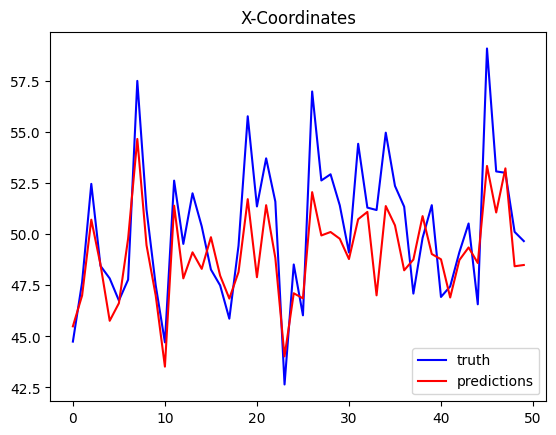

In [ ]:
import matplotlib.pyplot as plt
data_points['x']
predictions['x']
plt.plot(data_points['x'], color = 'b', label = 'truth')
plt.plot(predictions['x'], color = 'r', label = 'predictions')
plt.title(label = "X-Coordinates")
plt.legend()
plt.show()

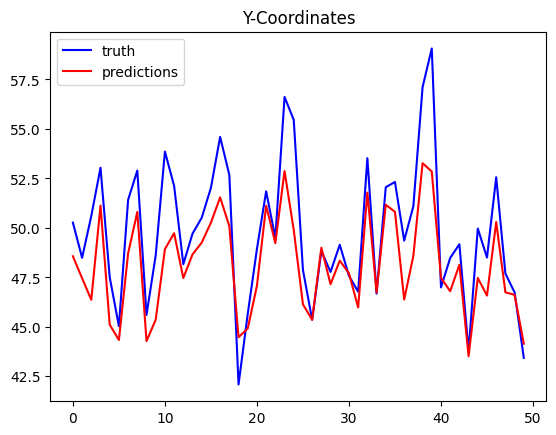

In [ ]:
import matplotlib.pyplot as plt
plt.plot(data_points['y'], color = 'b', label = 'truth')
plt.plot(predictions['y'], color = 'r', label = 'predictions')
plt.title(label = "Y-Coordinates")
plt.legend()
plt.show()

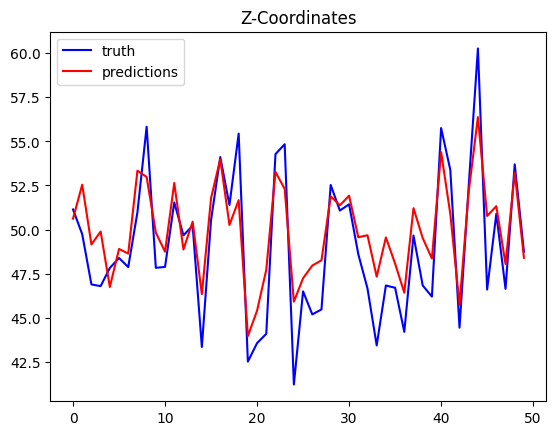

In [ ]:
import matplotlib.pyplot as plt
plt.plot(data_points['z'], color = 'b', label = 'truth')
plt.plot(predictions['z'], color = 'r', label = 'predictions')
plt.title(label = "Z-Coordinates")
plt.legend()
plt.show()